In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from tqdm import tqdm
import os
sns.set()

In [11]:
import random
df = pd.read_csv(r'C:\Users\HP\Downloads\vn100_prices.csv', parse_dates=['TradingDate'])
df.set_index('TradingDate', inplace=True)
random_column = random.choice(df.columns)
df = df[[random_column]]
df

,VRE
TradingDate,
2021-07-15,28000
2021-07-16,27700
2021-07-19,26800
2021-07-20,26700
2021-07-21,27400
...,...
2024-06-03,22300
2024-06-04,22100
2024-06-05,22500


In [12]:
minmax = MinMaxScaler().fit(df.astype('float32'))  # Close index
df_log = minmax.transform(df.astype('float32'))  # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.455782
1,0.435374
2,0.374150
3,0.367347
4,0.414966


In [5]:
test_size = 30
simulation_size = 1

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]

In [13]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, encoder_output, decoder_state):
        # encoder_output shape == (batch_size, max_length, hidden_size)
        # decoder_state shape == (batch_size, hidden_size)

        # Expand dimensions to enable broadcasting
        decoder_state_with_time_axis = tf.expand_dims(decoder_state, 1)

        # Score shape == (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(self.W(encoder_output) + decoder_state_with_time_axis))

        # Attention weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Context vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class LSTMModel(tf.keras.Model):
    def __init__(
        self,
        num_layers,
        size_layer,
        output_size,
        attention_units,  # New parameter for attention mechanism
        dropout_rate=0.8,
        lambda_coeff=0.5
    ):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.size_layer = size_layer
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.lambda_coeff = lambda_coeff
        self.attention_units = attention_units  # Store attention units

        # Define LSTM cells
        self.rnn_cells = [tf.keras.layers.LSTMCell(size_layer) for _ in range(num_layers)]
        self.drop = tf.keras.layers.Dropout(rate=dropout_rate)
        self.rnn = tf.keras.layers.RNN(self.rnn_cells, return_sequences=True)

        # Attention mechanism
        self.attention = Attention(attention_units)

        # Dense layers for VAE outputs
        self.fc_z_mean = tf.keras.layers.Dense(output_size)
        self.fc_z_log_sigma = tf.keras.layers.Dense(output_size)
        self.fc_logits = tf.keras.layers.Dense(output_size)

    def call(self, inputs, training=None, mask=None):
        rnn_outputs = self.rnn(inputs)

        # Use the last RNN output as context vector from attention mechanism
        last_rnn_output = rnn_outputs[:, -1, :]

        # Calculate context vector using attention mechanism
        context_vector, _ = self.attention(rnn_outputs, last_rnn_output)

        # Feed context vector to calculate z_mean and z_log_sigma
        z_mean = self.fc_z_mean(context_vector)
        z_log_sigma = self.fc_z_log_sigma(context_vector)

        # Sample z_vector from z_mean and z_log_sigma
        epsilon = tf.random.normal(tf.shape(z_log_sigma))
        z_vector = z_mean + tf.exp(z_log_sigma) * epsilon

        # Prepare inputs for decoder (concatenate z_vector with inputs)
        decoder_inputs = tf.concat([tf.expand_dims(z_vector, axis=1), inputs], axis=1)

        # Pass decoder inputs through RNN
        decoder_outputs = self.rnn(decoder_inputs)

        # Predict logits for the output sequence
        logits = self.fc_logits(decoder_outputs[:, 1:, :])

        return logits, z_mean, z_log_sigma

In [14]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [15]:
num_layers = 1
size_layer = 64
timestamp = 3
epoch = 10
dropout_rate = 0.8
learning_rate = 0.01
attention_units = 64

In [18]:
def forecast():
    model = LSTMModel(num_layers, size_layer, df_log.shape[1], attention_units, dropout_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    train_losses = []
    val_losses = []

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0)
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
            batch_y = df_train.iloc[k + 1:index + 1, :].values

            with tf.GradientTape() as tape:
                logits, z_mean, z_log_sigma = model(batch_x)
                reconstruction_loss = tf.reduce_mean(tf.square(batch_y - logits))
                kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * z_log_sigma - z_mean ** 2 - tf.exp(2 * z_log_sigma), axis=1)
                kl_loss = tf.reduce_mean(kl_loss)
                total_loss.append(reconstruction_loss + model.lambda_coeff * kl_loss)

            gradients = tape.gradient(total_loss[-1], model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))

        train_losses.append(np.mean(total_loss))
        val_loss = validate(model)
        val_losses.append(val_loss)

        pbar.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1])

    plot_loss(train_losses, val_losses)

    future_day = test_size
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(df_train.iloc[k:k + timestamp], axis=0)
        logits, _, _ = model(batch_x)  # Adjusted to handle three return values
        output_predict[k + 1:k + timestamp + 1] = logits.numpy()

    init_value = _

    if (df_train.shape[0] // timestamp) * timestamp != df_train.shape[0]:
        batch_x = np.expand_dims(df_train.iloc[-timestamp:], axis=0)
        logits, _, _ = model(batch_x)  # Adjusted to handle three return values
        output_predict[-timestamp:] = logits.numpy()
        future_day -= timestamp
        date_ori.append(date_ori[-1] + timedelta(days=1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        logits, _, _ = model(np.expand_dims(o, axis=0))  # Adjusted to handle three return values
        output_predict[-future_day + i] = logits.numpy()[0][-1]  # Ensure correct indexing for logits

    date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

def validate(model):
    total_loss = []
    for k in range(0, df_train.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_train.shape[0] - 1)
        batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0)
        batch_y = df_train.iloc[k + 1:index + 1, :].values

        logits, z_mean, z_log_sigma = model(batch_x)
        reconstruction_loss = tf.reduce_mean(tf.square(batch_y - logits))
        kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * z_log_sigma - z_mean ** 2 - tf.exp(2 * z_log_sigma), axis=1)
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss.append(reconstruction_loss + model.lambda_coeff * kl_loss)

    return np.mean(total_loss)

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

simulation 1


train loop:   0%|          | 0/10 [00:00<?, ?it/s]

train loop: 100%|██████████| 10/10 [03:02<00:00, 18.21s/it, train_loss=0.0245, val_loss=0.197]


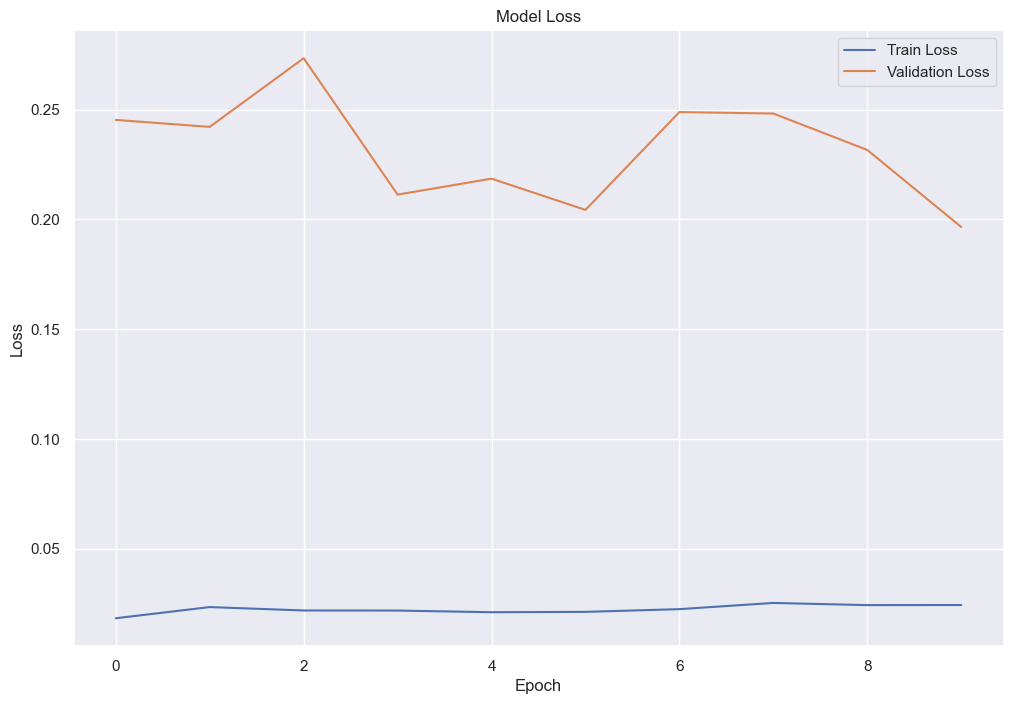

In [19]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i+1))
    results.append(forecast())

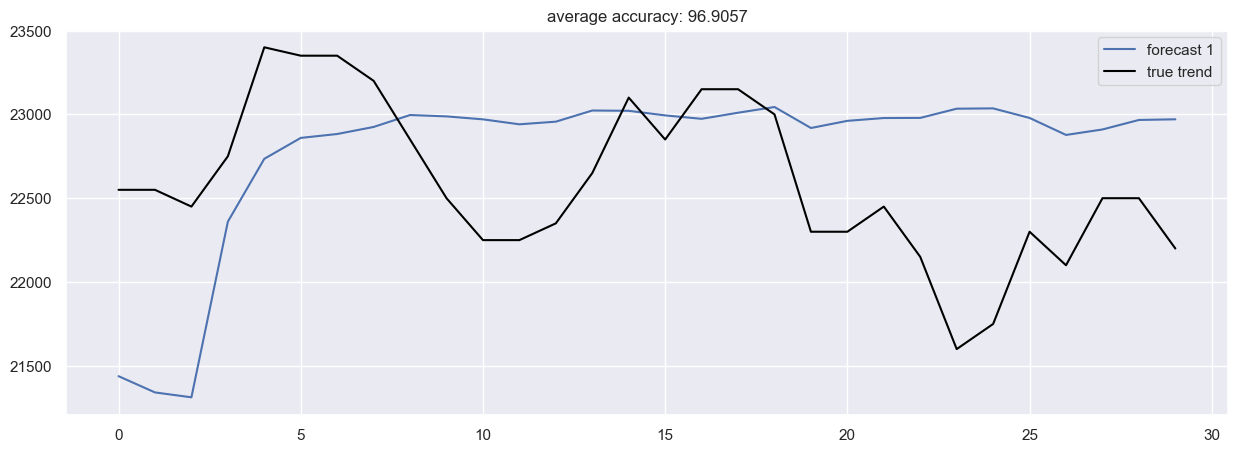

In [21]:
accuracies = [calculate_accuracy(df.iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df.iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()